{download}`Download this notebook <3_karate_club.ipynb>`

## Zachary's karate club
> **`gradnet` concepts demonstrated below**
> - Initial adjacency A₀ - optimal modifications of an existing network 
> - Edge removal `delta_sign="nonpositive"`
> - Restricted signs of final edgeweights `final_sign="nonnegative"`
> - Custom loss and ODE integration
> - Checkpointing
### Problem setup
Zachary's karate club is a classic social network of 34 members whose friendships were recorded by Wayne Zachary in the 970s. A conflict between the instructor and the club president eventually caused the club to split into two factions, making it a standard example for community detection.

In this tutorial, we take an opinion dynamics view: the instructor and president hold fixed, opposing opinions that diffuse through the network. Friendships then rewire to reduce social dissonance, favoring ties between members with similar opinions, which subsequently splits the graph in two components.

The opinion dynamics is given by a simple **diffusion** process
$$\dot o(t) = -\,L\,o(t).$$
Here $L$ is the Laplacian, defined as $L = D - A$ with adjacency matrix $A$ and the diagonal matrix of node degrees $D_{ii}=\sum_j A_{ij}$. The opinions of the president and the instructor are fixed $o_1(t)=1,\;o_N(t)=-1$. The **social dissonance** is measured by the weighted sum of disagreements with friends:
$$
\mathcal{D} = \frac{\sum_{i,j} A_{ij}\,\big(o_i - o_j\big)^2}{\sum_{i,j} A_{ij}}.
$$

### GradNet optimization

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /Users/guga/D/University/UWyo/Network_Optimization/gradnet/examples/karate_club_checkpoints exists and is not empty.


Updates:   0%|          | 0/200 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 1.2 K  | train
-----------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=200` reached.
/Users/guga/D/University/UWyo/Network_Optimization/gradnet/src/gradnet/gradnet.py:750: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless 

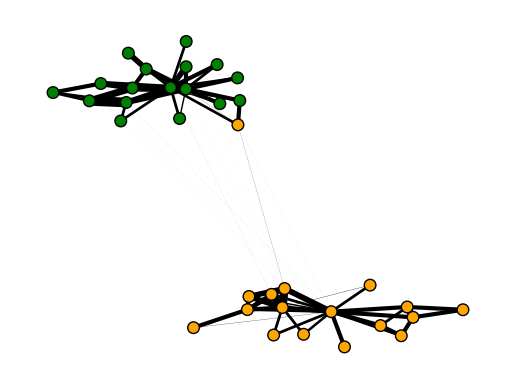

In [4]:
from gradnet import GradNet
from gradnet.trainer import fit
from gradnet.utils import plot_graph
import torch
import networkx as nx
from gradnet.ode import integrate_ode


karate_net = nx.karate_club_graph()  # Load Zachary's Karate Club graph
adj0 = nx.to_numpy_array(karate_net)  # Get adjacency matrix as a NumPy array
mask = (adj0 > 0).astype(float)  # mask every non-existant edge

N = len(karate_net)
budget = 100  # let's give it a large amount of budget and allow it to use as much of it as it likes

gn = GradNet(num_nodes=N, adj0=adj0, mask = mask, delta_sign="nonpositive", final_sign="nonnegative",
            budget=budget, rand_init_weights=0.0001, use_budget_up=False)


def do_dt(t, o, A):
    '''Diffusion of opinions with fixed opinion leaders '''
    L = torch.diag(A.sum(dim=1)) - A
    do = - L@o
    do[0] = 0
    do[-1] = 0
    return do

def dissonans(adj, o):
    o_dif = (o.unsqueeze(-1)-o.unsqueeze(-2))**2
    return (adj*o_dif).sum()/adj.sum()

def loss_fn(gn, relaxation_time=10):
    adj = gn()

    tt = torch.linspace(0, relaxation_time, 50)  # time grid to evaluate the numerical solutions
    o0 = torch.zeros(N)  # set the initial opinions to 0
    o0[0] = 1  # administrator
    o0[-1] = -1  # instructor

    tt, oo = integrate_ode(adj, f=do_dt, x0=o0, tt=tt)  # integrate the ODE
    o = oo[-1]
    
    return dissonans(adj, o), {"used_b": gn.get_delta_adj().sum().item()}  #compute dissonance

_, best_ckpt  = fit(gn=gn, loss_fn=loss_fn, num_updates=200, optim_kwargs={"lr": 0.01}, 
                    accelerator="cpu", enable_checkpointing=True, 
                    checkpoint_dir="./karate_club_checkpoints");

gn_best = GradNet.from_checkpoint(best_ckpt)
# Color nodes based on the club they joined after the split
col = ['orange' if karate_net.nodes[nd]['club']== 'Mr. Hi' else 'green' for nd in range(N)]
plot_graph(gn_best, node_size=70, draw_kwargs={"node_color": col})

The edges represent the friendships after the social dissonance has been minimized. You can see that the network has split into two factions. The node collors, on the other hand, represent the ground truth: which club member sided with who. The network split coming from the opinion diffusion model matches with the ground truth except for one member, who is usually misclassified by most other algorithms. 